**Prediction for energy requirement**

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime

from scipy.stats.mstats import winsorize
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stl.mstl import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

from fbprophet import Prophet
from sklearn.preprocessing import OneHotEncoder

**Data cleaning:**

*Loading data*

*Handling duplication*
    
*Handling missing data*

Missing 14 data points before impute
Missing 0 data points after impute


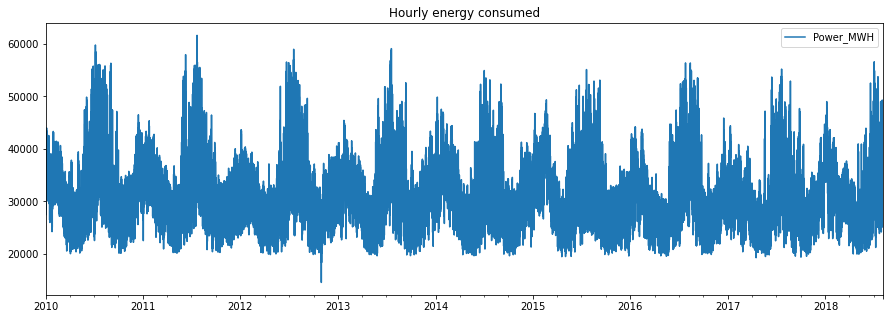

                     Power_MWH
2010-01-01 00:00:00    31647.0
2010-01-01 01:00:00    30075.0
2010-01-01 02:00:00    28907.0
                     Power_MWH
2018-08-02 22:00:00    41552.0
2018-08-02 23:00:00    38500.0
2018-08-03 00:00:00    35486.0


In [223]:
df = pd.read_csv('./power_data.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop(columns=df.columns[0],inplace = True)

# Date time is not sorted
df.sort_values(by=['Datetime'])

# Check duplication and drop the later records
df.drop_duplicates(subset='Datetime', keep='first', inplace=True)

# Check missing data point and impute with linear interpolation
df.index = pd.to_datetime(df['Datetime'])
df.drop(columns=df.columns[0],inplace = True)
date_range = pd.date_range(df.index.min(), df.index.max(), freq="1H")
print("Missing {} data points before impute".format(len(date_range.difference(df.index))))
df = df.reindex(date_range)
df['Power_MWH'].interpolate(inplace=True)
print("Missing {} data points after impute".format(len(date_range.difference(df.index))))

df.plot(
    figsize=(15, 5),
    title='Hourly energy consumed')
plt.show()

print(df.head(3))
print(df.tail(3))

# Test/Train split
df_train = df.loc[df.index < '2017-01-01']
df_test = df.loc[df.index >= '2017-01-01']

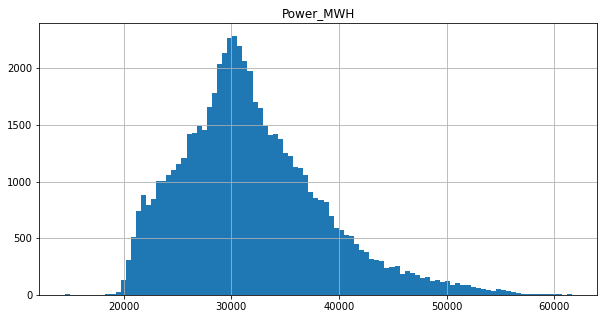

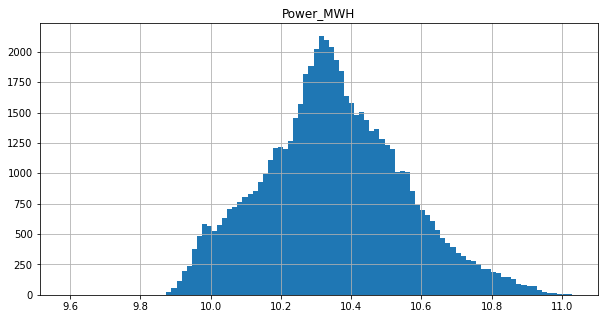

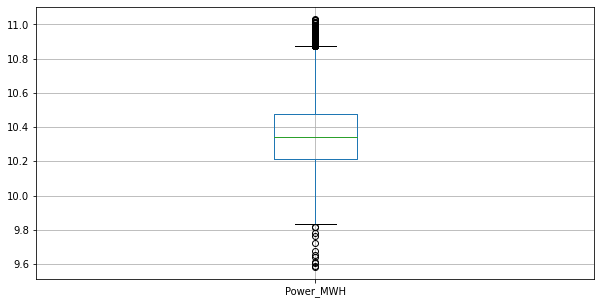

/var/folders/z0/s0q2v3kn0b145_kjfj_sd4pr0000gn/T/ipykernel_16154/4153936302.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Power_MWH'] = winsorized_data


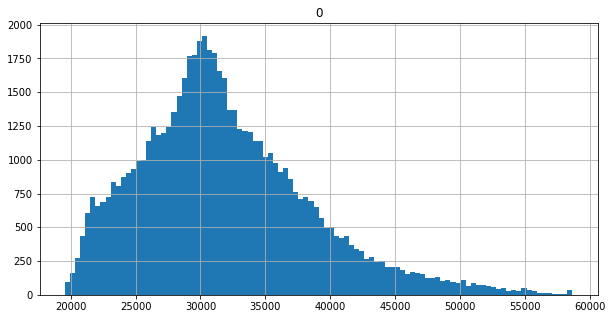

In [224]:
#Look for and adjust the outliers
df_train.hist(figsize=(10, 5), bins=100)
plt.show()

df_train_log = np.log(pd.DataFrame(df_train))
df_train_log.hist(figsize=(10, 5), bins=100)
plt.show()

df_train_log.boxplot(figsize=(10, 5))
plt.show()

# we fine one on each side and adjust them
winsorized_data = winsorize(df_train['Power_MWH'],(0.0004))
pd.DataFrame(winsorized_data).hist(figsize=(10, 5), bins=100)
df_train['Power_MWH'] = winsorized_data
#Check the stationarity
#adf_result = adfuller(df_train)
#print('p-value: %f' % adf_result[1])

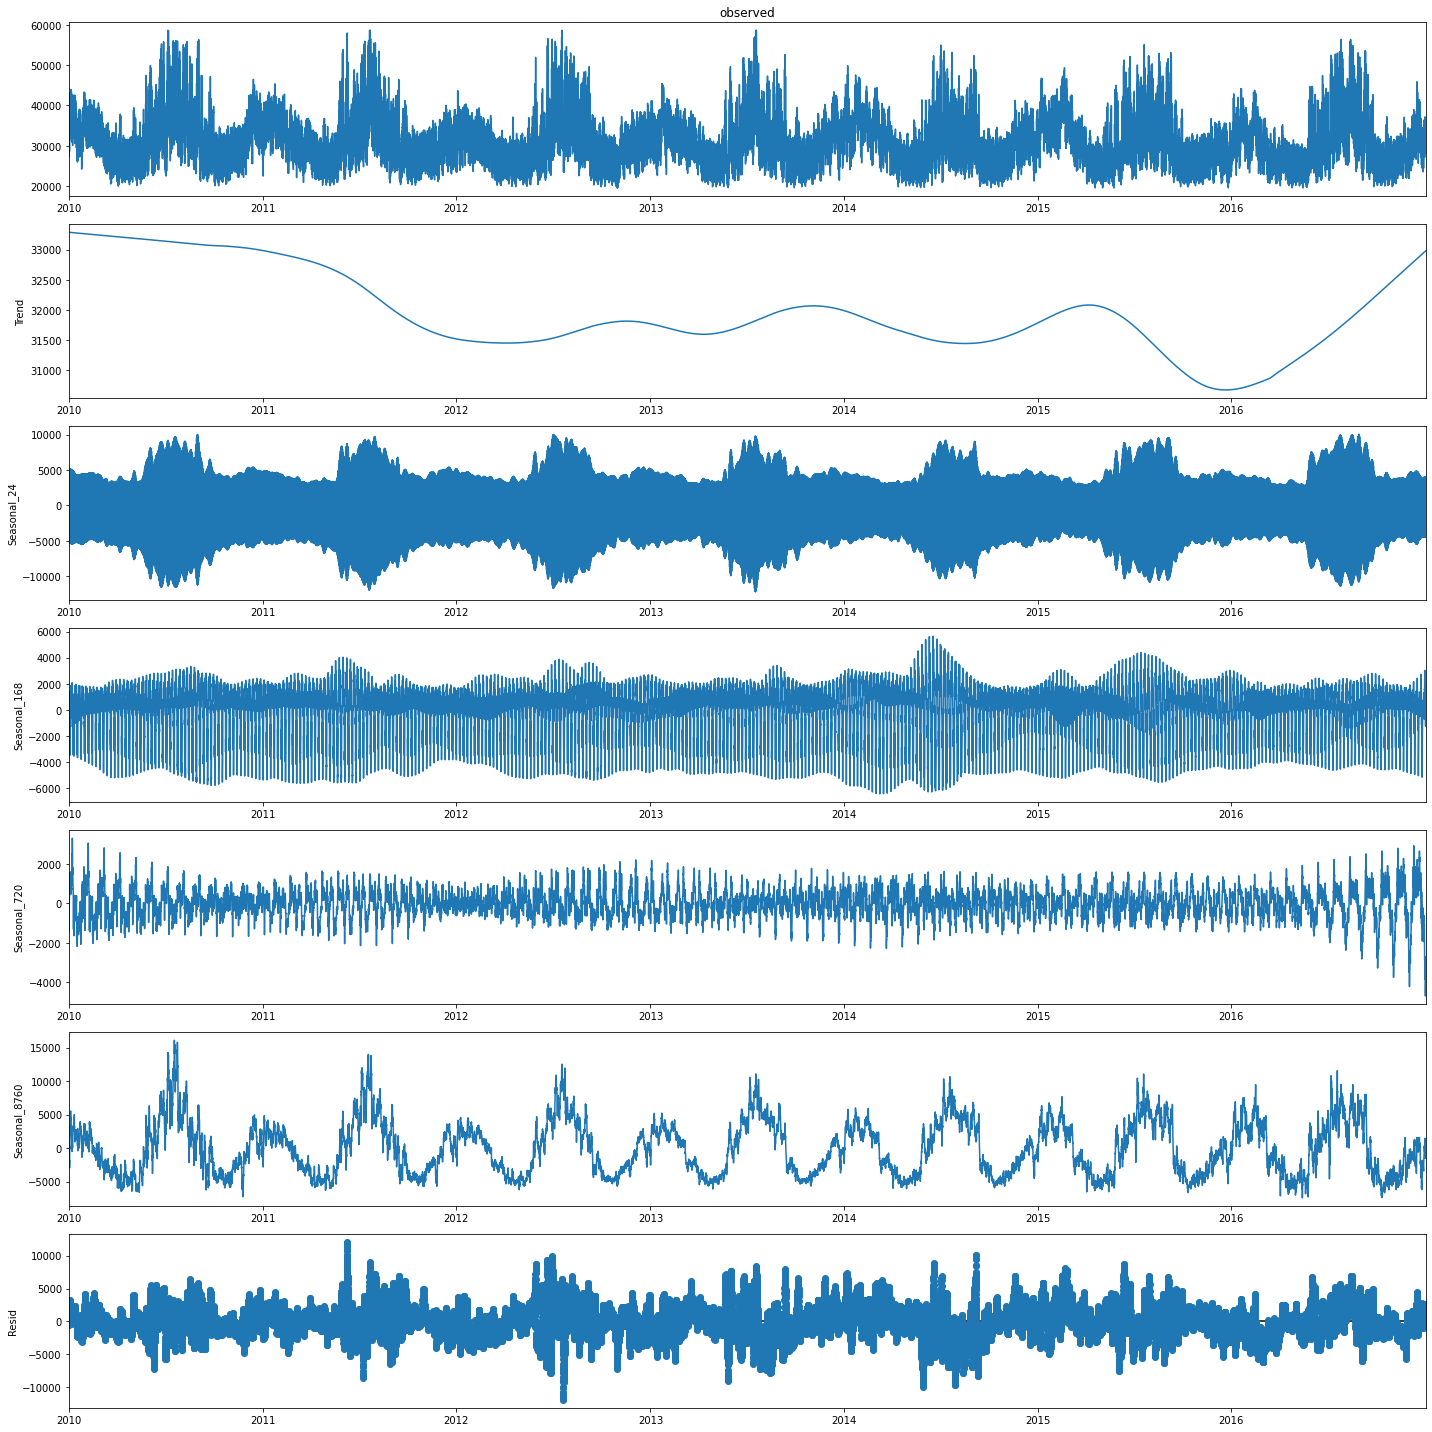

In [225]:
#Find the seasonlities using MSTL
mstl = MSTL(df_train, periods=[24, 24 * 7, 24 * 30, 24 * 365])  #24 * 30, 24 * 365
res = mstl.fit()
plt.rcParams["figure.figsize"] = (20, 20)
#fig = plt.figure(figsize=(100,20))
ax = res.plot()
plt.tight_layout()
plt.show()

0.05444302382454117

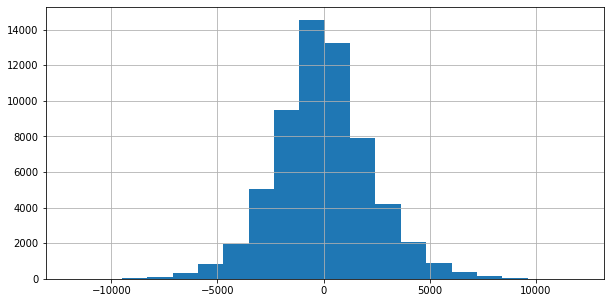

In [226]:
# check the ratio between trend and residual
res.resid.hist(figsize=(10, 5), bins = 20)
np.mean(abs(res.resid/res.trend))

Data description:
1. Hourly univariate time series data

2. Data is stationary

3. Multi seasonalities (hourly, daily, weekly, monthly, yearly)

4. Relevant clean data without significant outliers

5. High noise, we can see the residual from MSTL is

Potential base models：
1. STL (cons: only deal with one season)
2. MSTL / Prophet 
    (cons: 

    MSTL has not implemented a forecast functionality yet
    
    Prophet has only daily, weekly and yearly, missing monthly we wanted to detect
    )
3. ARIMA (cons: not the best when dealing with high frequency and multi seasonalities data, with a couple of season periods, the result will have low variance)
4. Linear regression (time concern, we will need to choose and remove features often)

Machine learning models:
1. gbm: xgboost, lgbm, catgbm
2. NN: rnn, lstm

Overall, we will go with Prophet to build the base model.

                           y                  ds
2017-01-01 00:00:00  28171.0 2017-01-01 00:00:00
2017-01-01 01:00:00  26879.0 2017-01-01 01:00:00
2017-01-01 02:00:00  25848.0 2017-01-01 02:00:00
2017-01-01 03:00:00  25039.0 2017-01-01 03:00:00
2017-01-01 04:00:00  24637.0 2017-01-01 04:00:00


/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -399.86
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        138847       0.04477       15187.5           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        139828     0.0450246       11239.7           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        139975    0.00645161          2368      0.7705      0.7705      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        140180     0.0252055       4135.24           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        140220   0.000882252       1077.86           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

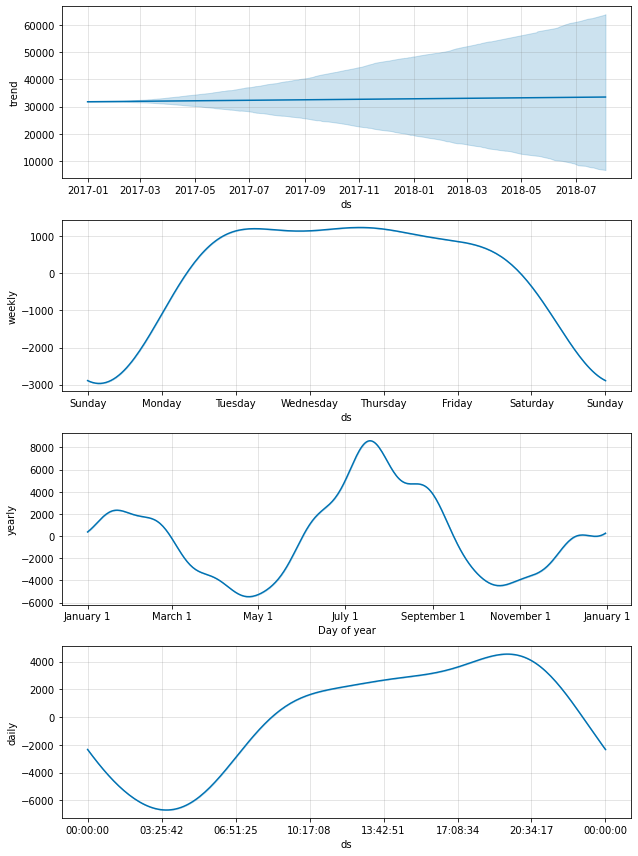

In [235]:
# Prophet model
df_train_prophet = df_train.copy()
df_train_prophet['ds'] = df_train_prophet.index
df_train_prophet.rename(columns={'Power_MWH': 'y'},inplace=True)
df_train_prophet.head()

df_test_prophet = df_test.copy()
df_test_prophet['ds'] = df_test_prophet.index
df_test_prophet.rename(columns={'Power_MWH': 'y'},inplace=True)
print(df_test_prophet.head())

model = Prophet()
model.fit(df_train_prophet)

df_test_forecast = model.predict(df=df_test_prophet)
df_test_forecast.head()
fig = model.plot_components(df_test_forecast)

Found from the decompositions:
1. Trend holds big variance, which will leads to an uncertainty for prediction
2. Yearly trend shows two peak on Jan and July, we can assume the data is from somewhere has four distinct seasons.
3. Weekly data shows less energy required during weekends
4. Daily data shows peak around 8pm and trough around 3:30am

(17743.0, 17744.0)

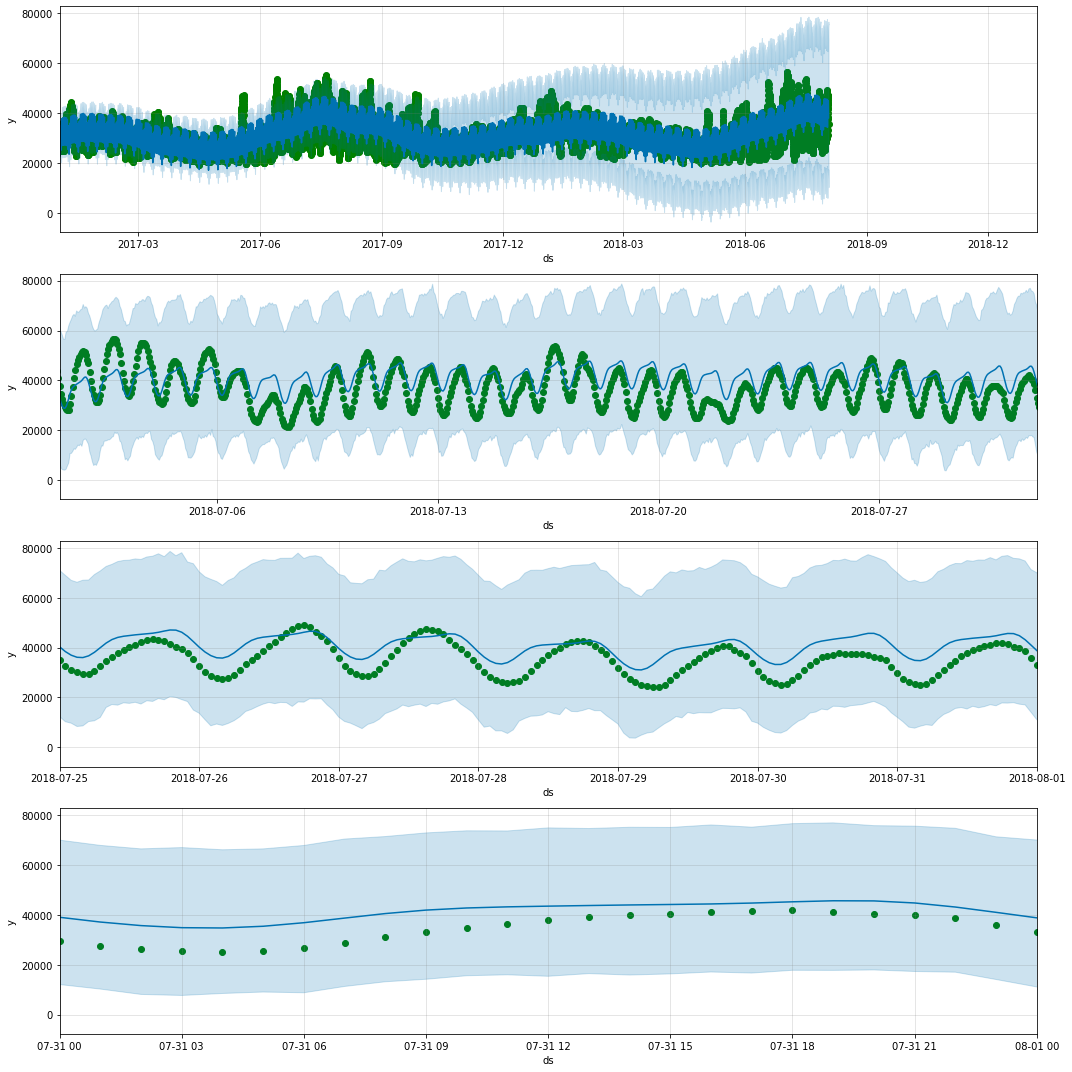

In [236]:
# Result Display
f, (ax_whole, ax_month, ax_week, ax_day) = plt.subplots(4,1)
f.set_figheight(15)
f.set_figwidth(15)
ax_whole.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_forecast, ax=ax_whole)
ax_whole.set_xlim(xmin = pd.to_datetime('2017-01-01'))

ax_month.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_forecast, ax=ax_month)
ax_month.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-01']))

ax_week.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_forecast, ax=ax_week)
ax_week.set_xlim(pd.to_datetime(['2018-07-25', '2018-08-01']))

ax_day.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_forecast, ax=ax_day)
ax_day.set_xlim(pd.to_datetime(['2018-07-31', '2018-08-01']))

The hourly MAE on the test set is : 
 12.263605410666534%
The daily sum MAE on the test set is : 
 10.136463590513996%


<AxesSubplot:xlabel='ds'>

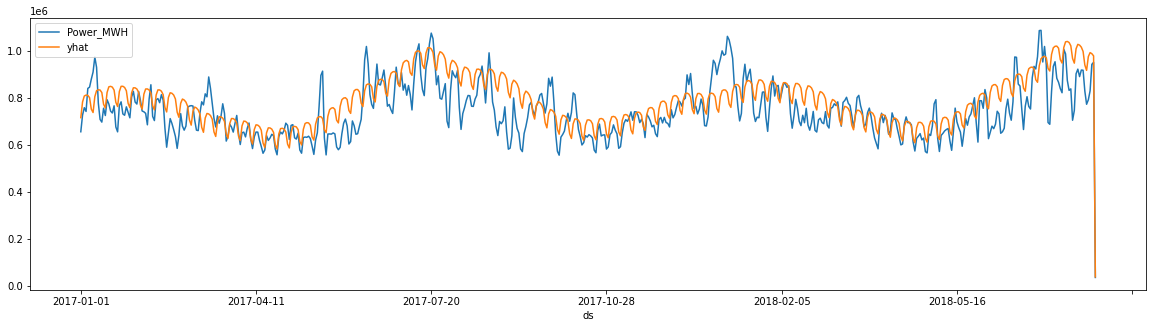

In [263]:
# Choose matric
# Prediction is high volumn, compare to MSE or MAE, MAPE is easier to explain.
def mape(test, forecast): 
    test, forecast = np.array(test), np.array(forecast)
    return np.mean(np.abs((test - forecast) / test)) * 100
    
mae = mape(df_test['Power_MWH'],df_test_forecast['yhat'])

print("The hourly MAE on the test set is : \n {}%".format(mae))

daily_forecast = pd.DataFrame(df_test_forecast['yhat'])
daily_forecast.index = pd.DatetimeIndex(df_test_forecast['ds'])
daily_forecast = daily_forecast.groupby([lambda x: x.strftime("%Y-%m-%d")]).sum()
daily_test = df_test.groupby([lambda x: x.strftime("%Y-%m-%d")]).sum()

mae_daily = mape(daily_test['Power_MWH'],daily_forecast['yhat'])

print("The daily sum MAE on the test set is : \n {}%".format(mae_daily))

ax = daily_test.plot(legend='actual', figsize=(20, 5), label='actual') 
daily_forecast.plot(ax=ax, label='predict')



The above model treated the data as univariate time series data, there was no feature obtained. To furthur test out the model, we can introduce some features
Adding features in Prophet

# Feature engineering

# Numerical features (linear relations with target)
    # Temperature (Need location and more information)
    # Year (can be used as trend, however we are not seeing stable trend from previous test)
# Categorical features
    # Season (4 categories, proved to be valid from the seasonality)
    # Month (12 categories, proved to be valid from the seasonality, correlated with seasons)
    # Week (53 categories, proved to be valid from the seasonality, correlated with months and seasons)

    # DOY: day of the year (365 or 366 categories, it might create computation problem and undersample problem, and also high correlated with month and week)
    # DOM: day of the month (around 30 categories, we are not seeing strong seasonality from previous test)
    # DOW: day of the week (7 categories, proved to be valid from the seasonality)
    # Holiday: is the day a local hoiday (bool, need location information)
    
    ## we don't need this since it's a daily prediction
    # HOD: hour of the day (24 categories, proved to be valid from the seasonality)

    # feature interaction:
        # Detailize the season effects with human activities
            ## we don't need this since it's a daily prediction
            # Season * HOD * DOW (4*3*2 categories, if HOD can be aggregated into bins (home, out, sleep) DOW can be aggregated into bins (weekday, weekend))
            
            # Season * DOW (4*2 categories, DOW can be aggregated into bins (weekday, weekend))
        # Work from home effect, since the pandanmic, more people work from home and create different pattern of energy usage
            # Pandanmic: (bool, need location information, only will be use for later data, since the dataset if ended in 2018)


In [264]:
# Feature engineering
def get_season(date):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    seasons = []
    for d in date:
        if d in spring:
            seasons.append('spring')
        elif d in summer:
            seasons.append('summer')
        elif d in fall:
            seasons.append('fall')
        else:
            seasons.append('winter')
    return seasons

def get_activity(hours):
    active = range(11, 21)
    sleep = range(0, 7)
    hour_bins = []
    for i in hours:
        if i in active:
            hour_bins.append('active')
        elif i in sleep:
            hour_bins.append('sleep')
        else:
            hour_bins.append('normal')
    return hour_bins

def get_features(df_input):

    df = pd.DataFrame()
    df.index = df_input.index
    df['ds'] = df_input.index
    df['year'] = df_input.index.year
    df['season'] = get_season(df_input.index.dayofyear)
    df['month'] = df_input.index.month.astype(str)
    print(df['month'][1])
    df['week'] = df_input.index.weekofyear.astype(str)

    #df['DOY'] = df.index.dt.dayofyear
    df['DOM'] = df_input.index.day.astype(str)
    df['DOW'] = df_input.index.dayofweek
    df['HOD'] = df_input.index.hour

    df['weekday'] = (df['DOW']<5).apply(str)
    df["season_HOD"] = df['season'] + get_activity(df['HOD'])
    df["season_DOW"] = df['season'] + df['weekday']
    df["HOD_DOW"] = get_activity(df['HOD']) + df['weekday']
    df["season_HOD_DOW"] = df['season'] + get_activity(df['HOD']) + df['weekday']
    df['y'] = df_input['Power_MWH']
    
    df.drop(columns=['weekday'], inplace = True)
    df['DOW'] = df['DOW'].astype(str)
    df['HOD'] = df['HOD'].astype(str)
    return df

df_train_featured = get_features(df_train)
df_test_featured = get_features(df_test)

df_train_featured.head(5).append(df_train_featured.tail(5))

1


/var/folders/z0/s0q2v3kn0b145_kjfj_sd4pr0000gn/T/ipykernel_16154/81076929.py:40: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df_input.index.weekofyear.astype(str)
/var/folders/z0/s0q2v3kn0b145_kjfj_sd4pr0000gn/T/ipykernel_16154/81076929.py:40: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df_input.index.weekofyear.astype(str)


1


/var/folders/z0/s0q2v3kn0b145_kjfj_sd4pr0000gn/T/ipykernel_16154/81076929.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_featured.head(5).append(df_train_featured.tail(5))


,ds,year,season,month,week,DOM,DOW,HOD,season_HOD,season_DOW,HOD_DOW,season_HOD_DOW,y
2010-01-01 00:00:00,2010-01-01 00:00:00,2010,winter,1,53,1,4,0,wintersleep,winterTrue,sleepTrue,wintersleepTrue,31647.0
2010-01-01 01:00:00,2010-01-01 01:00:00,2010,winter,1,53,1,4,1,wintersleep,winterTrue,sleepTrue,wintersleepTrue,30075.0
2010-01-01 02:00:00,2010-01-01 02:00:00,2010,winter,1,53,1,4,2,wintersleep,winterTrue,sleepTrue,wintersleepTrue,28907.0
2010-01-01 03:00:00,2010-01-01 03:00:00,2010,winter,1,53,1,4,3,wintersleep,winterTrue,sleepTrue,wintersleepTrue,27906.0
2010-01-01 04:00:00,2010-01-01 04:00:00,2010,winter,1,53,1,4,4,wintersleep,winterTrue,sleepTrue,wintersleepTrue,27373.0
2016-12-31 19:00:00,2016-12-31 19:00:00,2016,winter,12,52,31,5,19,winteractive,winterFalse,activeFalse,winteractiveFalse,34478.0
2016-12-31 20:00:00,2016-12-31 20:00:00,2016,winter,12,52,31,5,20,winteractive,winterFalse,activeFalse,winteractiveFalse,33328.0
2016-12-31 21:00:00,2016-12-31 21:00:00,2016,winter,12,52,31,5,21,winternormal,winterFalse,normalFalse,winternormalFalse,32197.0
2016-12-31 22:00:00,2016-12-31 22:00:00,2016,winter,12,52,31,5,22,winternormal,winterFalse,normalFalse,winternormalFalse,30909.0
2016-12-31 23:00:00,2016-12-31 23:00:00,2016,winter,12,52,31,5,23,winternormal,winterFalse,normalFalse,winternormalFalse,29519.0


/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -399.86
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        144686    0.00488687        6841.9           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        145289     0.0361799       39078.4           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        145646   0.000713906       3896.85      0.4341      0.4341      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        145861     0.0313073       26851.2           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        146176    0.00532147         10203           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minxiangliu/miniforge3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

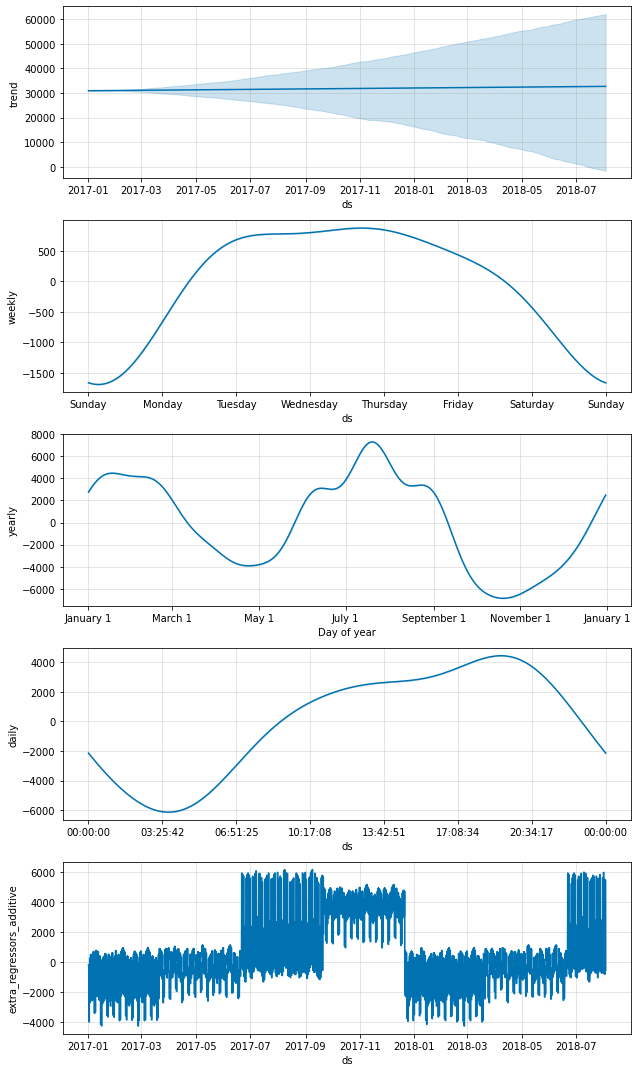

In [265]:
# Prophet model

# OneHotEncode for categorical data
encoded_df_train_featured = df_train_featured[['ds','y']]
encoded_df_train_featured.reset_index(drop=True, inplace=True)
encoded_df_test_featured = df_test_featured[['ds','y']]
encoded_df_test_featured.reset_index(drop=True, inplace=True)

exogenous_features = ['season', 'DOM', 'season_HOD', 'season_DOW', 'HOD_DOW', 'season_HOD_DOW']
#exogenous_features = ['season', 'DOM', 'season_HOD', 'season_DOW', 'HOD_DOW', 'season_HOD_DOW']
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(df_train_featured[exogenous_features]).toarray()
feature_names = oe_style.get_feature_names_out(exogenous_features)
encoded_df_train_featured = pd.concat([encoded_df_train_featured, 
               pd.DataFrame(oe_results,columns=feature_names).astype(int)], axis=1)

oe_test_results = oe_style.transform(df_test_featured[exogenous_features]).toarray()
encoded_df_test_featured = pd.concat([encoded_df_test_featured, 
               pd.DataFrame(oe_test_results,columns=feature_names).astype(int)], axis=1)

model_features = Prophet()
for feature in feature_names:
	model_features.add_regressor(feature)
model_features.fit(encoded_df_train_featured)

df_test_featured_forecast = model_features.predict(df=encoded_df_test_featured)
df_test_featured_forecast.head()
fig = model_features.plot_components(df_test_featured_forecast)

The hourly MAE on the feaured test set is : 
 11.57073907222749%
The daily sum MAE on the test set is : 
 10.205043140883802%


<AxesSubplot:title={'center':'Daily actual and prediction'}, xlabel='ds'>

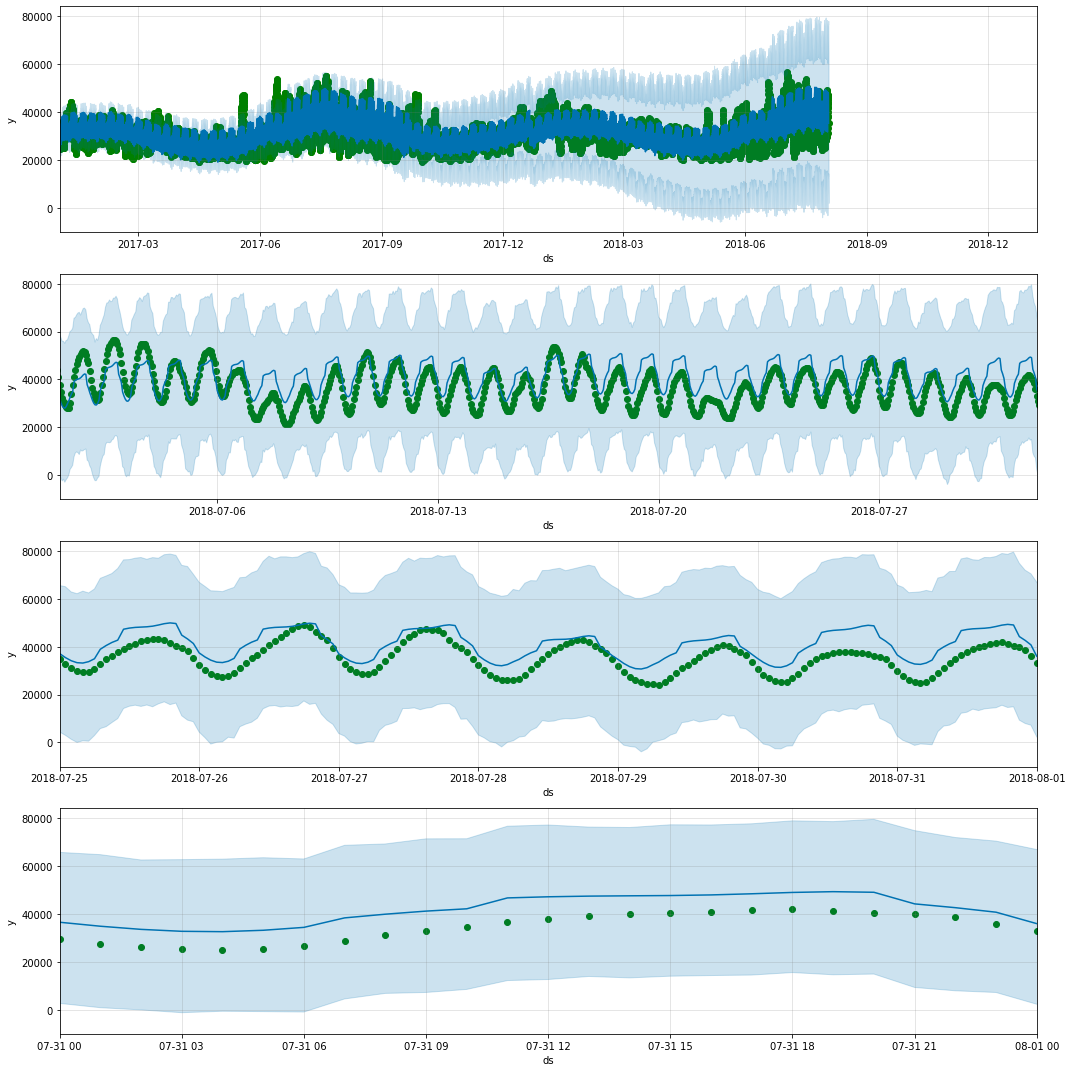

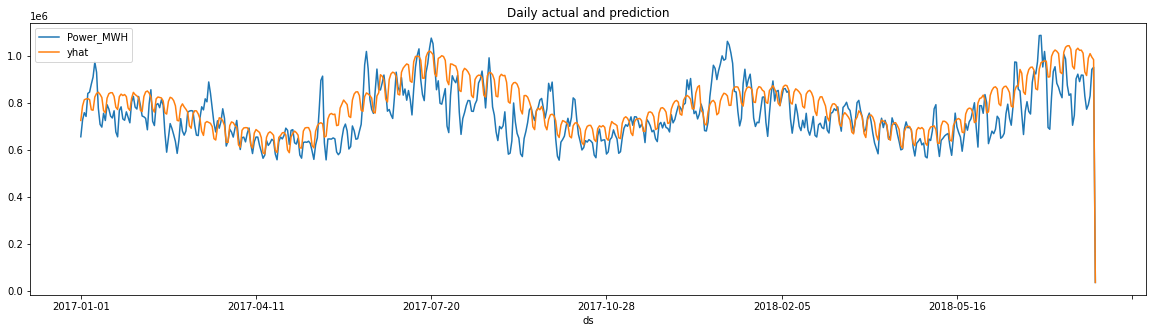

In [268]:
# Result Display
f, (ax_whole, ax_month, ax_week, ax_day) = plt.subplots(4,1)
f.set_figheight(15)
f.set_figwidth(15)
ax_whole.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_featured_forecast, ax=ax_whole)
ax_whole.set_xlim(xmin = pd.to_datetime('2017-01-01'))

ax_month.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_featured_forecast, ax=ax_month)
ax_month.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-01']))

ax_week.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_featured_forecast, ax=ax_week)
ax_week.set_xlim(pd.to_datetime(['2018-07-25', '2018-08-01']))

ax_day.scatter(df_test.index, df_test['Power_MWH'], color='g')
fig = model.plot(df_test_featured_forecast, ax=ax_day)
ax_day.set_xlim(pd.to_datetime(['2018-07-31', '2018-08-01']))
    
mae = mape(df_test['Power_MWH'],df_test_featured_forecast['yhat'])

print("The hourly MAE on the feaured test set is : \n {}%".format(mae))

daily_forecast = pd.DataFrame(df_test_featured_forecast['yhat'])
daily_forecast.index = pd.DatetimeIndex(df_test_featured_forecast['ds'])
daily_forecast = daily_forecast.groupby([lambda x: x.strftime("%Y-%m-%d")]).sum()
daily_test = df_test.groupby([lambda x: x.strftime("%Y-%m-%d")]).sum()

mae_daily = mape(daily_test['Power_MWH'],daily_forecast['yhat'])

print("The daily sum MAE on the test set is : \n {}%".format(mae_daily))

ax = daily_test.plot(legend='actual', figsize=(20, 5), label='actual', title="Daily actual and prediction") 
daily_forecast.plot(ax=ax, label='predict')

**With new features in, we are seeing the improve of hourly MAPE from 12.26% to 11.57%, but daily MAPE from 10.14% to 10.21%**

By futhur feature selection, we should be able to improve the reason a little bit more.

But for fundenmentally improve the result, we need to test out other ML methods, like XGBoost and LSTM

XGBoost

pros:
1. fast
2. less feature engineering methods
3. Outlier has less impact

cons:
1. hard to tune and easier to overfit

LSTM

pros: 
1. compare with CNN, it can deal with time series
2. compare with RNN, it can hold old information
    
cons:
1. limited training timestep
2. only for short term forecast, need iteration with coming data
3. slow of computation
4. compare to regular time series analsis method like Prophet，LSTM usually has worse performance on data with less volatility or higher frenquancy

Overall, I would go with XGBoost for next step.